# Prepare Passenger Data

The purpose of this notebook is to process the raw data in data/Houston Airports Passgengers.csv so that it is ready for time series analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(14,7)})

In [2]:
def process_airline_timeseries(data,campus,dom_intl,start_date='2001-01-01',fill_zeros_with=1):
    """ filters and prepares time series data
    
    Args:
        campus (str): the airport to select. one of "HOU", "IAH".
        dom_intl (str): whether domestic or international sector. one of "Domestic", "International"
        start_date (str or anything that can be parsed with pd.Timestamp): the earliest date to begin the time series.
        fill_zeros_with (int): if a time series has missing data, we assume that means zero passengers. replace zero with this value so that models don't fail later.
        
    Returns:
        (DataFrame): the prepared dataset.
    """
    df1 = data.loc[(data['CAMPUS'] == campus) & (data['Dom_Intl'] == dom_intl)]
    df2 = df1.groupby('Date')['PASSENGERS'].sum().reset_index()
    df3 = df2.loc[df2['Date'] >= pd.Timestamp(start_date)]
    dates = pd.DataFrame({'Date':pd.date_range(start=df3['Date'].min(),end=df3['Date'].max(),freq='MS')})
    df = dates.merge(df3,on='Date',how='left').fillna(fill_zeros_with)
    return df

In [3]:
raw_data = pd.read_csv('data/Houston Airports Passengers.csv',parse_dates=['Date'], encoding = 'unicode_escape')

In [4]:
raw_data.head()

,CAMPUS,COMPANY_NAME,Sched_Charter,TERMINAL,FIS_CHARGE,REGION,ARRIV_DEPART,PASSENGERS,Year,Month,Dom_Intl,Date,Direction,Airline
0,IAH,Kuwait Airlines,Scheduled,Terminal A,NaN,Asia,Arrive-Destination,25.0,2001,2,International,2001-02-01,Arrival,Kuwait Airlines
1,IAH,Kuwait Airlines,Scheduled,Terminal A,NaN,Asia,Depart-Local,27.0,2001,2,International,2001-02-01,Departure,Kuwait Airlines
2,IAH,"Air Jamaica, Ltd",Scheduled,Terminal A,NaN,Latin America,Depart-Local,269.0,2001,3,International,2001-03-01,Departure,Air Jamaica
3,IAH,Kuwait Airlines,Scheduled,Terminal A,NaN,Asia,Arrive-Destination,8.0,2001,4,International,2001-04-01,Arrival,Kuwait Airlines
4,IAH,Saudia,Scheduled,Terminal A,NaN,Europe,Arrive-Destination,14.0,2001,7,International,2001-07-01,Arrival,Saudia


In [5]:
pd.DataFrame(raw_data[['CAMPUS','Dom_Intl','Direction']].value_counts()).rename({0:'count'},axis=1)

count
CAMPUS Dom_Intl      Direction        
IAH    International Departure   18819
                     Arrival     17990
       Domestic      Arrival     13916
                     Departure   13680
       International Connection   7023
HOU    Domestic      Departure    4045
                     Arrival      4019
IAH    Domestic      Connection   3388
HOU    International Departure     369
                     Arrival       360
       Domestic      Connection    347
EFD    Domestic      Arrival       101
                     Departure      99
HOU    International Connection     11
EFD    Domestic      Connection      1

**For all series, we want departures and connections only.**

In [6]:
enplanements = raw_data.loc[raw_data['Direction'] != 'Arrival']
enplanements.head()

,CAMPUS,COMPANY_NAME,Sched_Charter,TERMINAL,FIS_CHARGE,REGION,ARRIV_DEPART,PASSENGERS,Year,Month,Dom_Intl,Date,Direction,Airline
1,IAH,Kuwait Airlines,Scheduled,Terminal A,NaN,Asia,Depart-Local,27.0,2001,2,International,2001-02-01,Departure,Kuwait Airlines
2,IAH,"Air Jamaica, Ltd",Scheduled,Terminal A,NaN,Latin America,Depart-Local,269.0,2001,3,International,2001-03-01,Departure,Air Jamaica
6,IAH,Sun Country Airlines,Scheduled,Terminal A,NaN,Mexico,Depart-Local,1056.0,2001,1,International,2001-01-01,Departure,Sun Country Airlines
8,IAH,Sun Country Airlines,Scheduled,Terminal A,NaN,Mexico,Depart-Local,1225.0,2001,2,International,2001-02-01,Departure,Sun Country Airlines
10,IAH,Sun Country Airlines,Scheduled,Terminal A,NaN,Mexico,Depart-Local,1350.0,2001,3,International,2001-03-01,Departure,Sun Country Airlines


**We want to keep Houston and IAH only.**

In [7]:
data = enplanements.loc[enplanements['CAMPUS'].isin(['HOU','IAH'])]
data.head()

,CAMPUS,COMPANY_NAME,Sched_Charter,TERMINAL,FIS_CHARGE,REGION,ARRIV_DEPART,PASSENGERS,Year,Month,Dom_Intl,Date,Direction,Airline
1,IAH,Kuwait Airlines,Scheduled,Terminal A,NaN,Asia,Depart-Local,27.0,2001,2,International,2001-02-01,Departure,Kuwait Airlines
2,IAH,"Air Jamaica, Ltd",Scheduled,Terminal A,NaN,Latin America,Depart-Local,269.0,2001,3,International,2001-03-01,Departure,Air Jamaica
6,IAH,Sun Country Airlines,Scheduled,Terminal A,NaN,Mexico,Depart-Local,1056.0,2001,1,International,2001-01-01,Departure,Sun Country Airlines
8,IAH,Sun Country Airlines,Scheduled,Terminal A,NaN,Mexico,Depart-Local,1225.0,2001,2,International,2001-02-01,Departure,Sun Country Airlines
10,IAH,Sun Country Airlines,Scheduled,Terminal A,NaN,Mexico,Depart-Local,1350.0,2001,3,International,2001-03-01,Departure,Sun Country Airlines


Now we process all time series and save them as CSVs. Houston International should start at 2016 due to aberrant values before that point. All zeros should be filled with value 1 so that no models in subsequent sections fail.

In [8]:
iahdom = process_airline_timeseries(data,'IAH','Domestic')
iahint = process_airline_timeseries(data,'IAH','International')
houdom = process_airline_timeseries(data,'HOU','Domestic')
houint = process_airline_timeseries(data,'HOU','International',start_date='2016-01-01')

Plot data to make sure all values are as expected. We notice a large COVID-related dip in each series.

[]

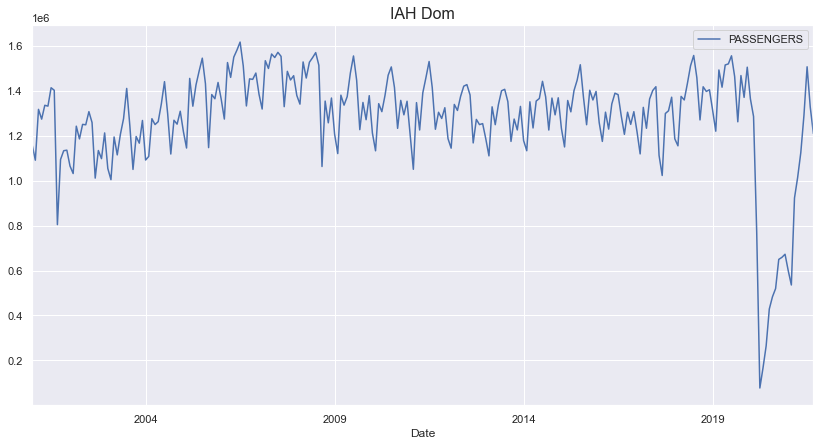

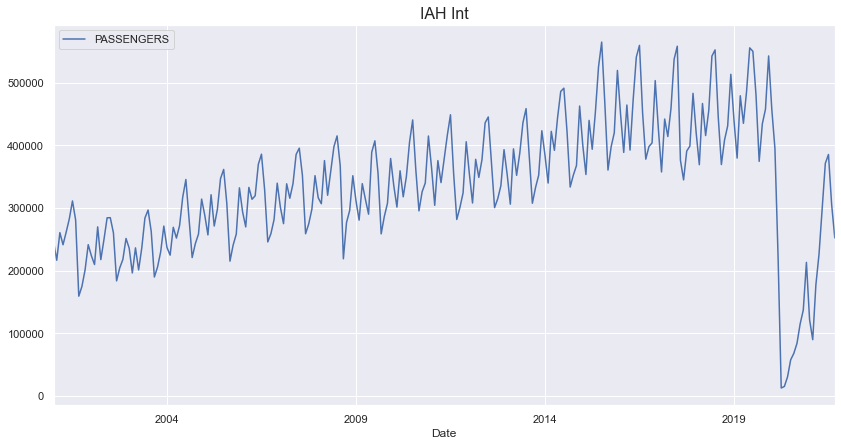

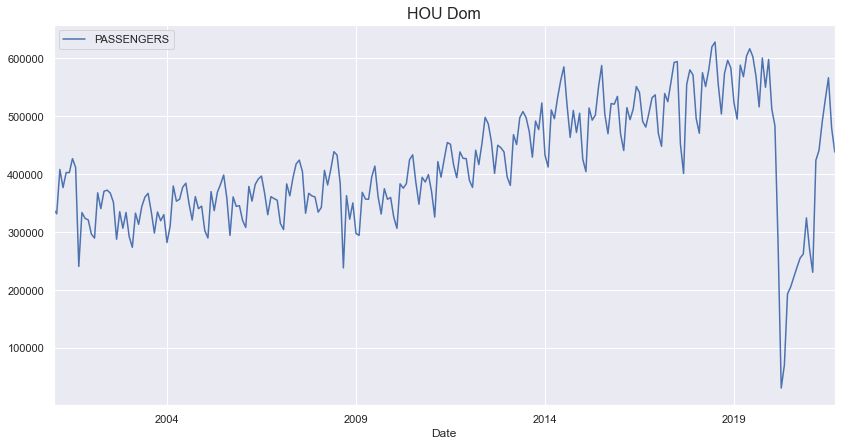

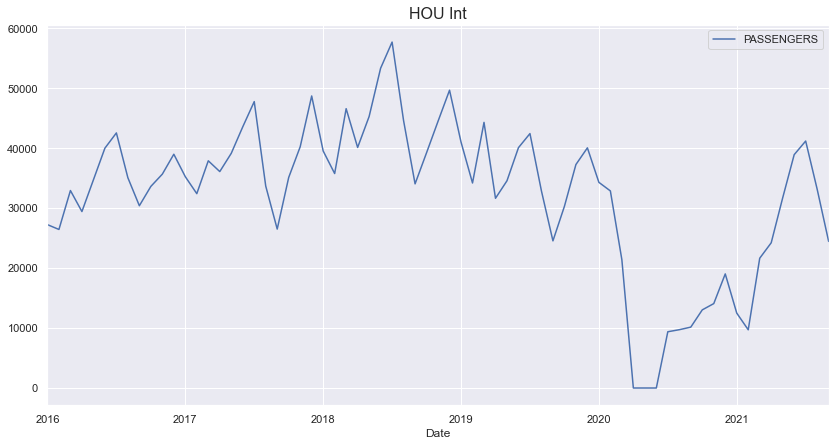

In [9]:
iahdom.plot(x='Date',y='PASSENGERS')
plt.title('IAH Dom',size=16)
plt.plot()
iahint.plot(x='Date',y='PASSENGERS')
plt.title('IAH Int',size=16)
plt.plot()
houdom.plot(x='Date',y='PASSENGERS')
plt.title('HOU Dom',size=16)
plt.plot()
houint.plot(x='Date',y='PASSENGERS')
plt.title('HOU Int',size=16)
plt.plot()

Write out prepared datasets.

In [10]:
iahdom.to_csv('data/IAH-Dom.csv',index=False)
iahint.to_csv('data/IAH-Int.csv',index=False)
houdom.to_csv('data/HOU-Dom.csv',index=False)
houint.to_csv('data/HOU-Int.csv',index=False)